In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import warnings

from quantipy.assets import Currency, Equity
from quantipy.trading import Broker, Strategy, TripleMovingAverage
from quantipy.backtest import Backtester
import quantipy.utils as _utils

%matplotlib inline
warnings.filterwarnings('ignore')

# backtest period
BACKTEST_START = '2016-01-01'
LIVE_START = '2019-01-01'

# trading universe
CAPITAL = 10_000
usd = Currency('USD')
spy = Equity('SPY', 'SPY')
ndq = Equity('NASDAQ', '^IXIC')
MKT = [spy, ndq]
BENCHMARK = 'SPY'

# strategy
# STRATEGY = TripleMovingAverage([spy], {})

class BuyAndHold(Strategy):
    def __init__(self, assets, params):
        super().__init__(assets, params)
        self.__buy = 1
    
    @property
    def asset(self):
        return self._Strategy__assets[0]
    
    def next(self, broker):
        if self.__buy:
            broker.logger.debug('Placing buy order')
            self.buy(self.asset, broker)
            self.__buy = 0

STRATEGY = BuyAndHold([spy], {})

In [2]:
# getting data
data = {}
for asset in MKT:
    ticker = yf.ticker.Ticker(asset.symbol)
    ticker_data = ticker.history(start=LIVE_START, interval='1d')
    data[asset.symbol] = ticker_data

broker = Broker(data=data, initial_capital=CAPITAL, currency=usd, commission_fixed=0, commission_pct=0)
live_backtester = Backtester(data)

backtest = live_backtester.run(STRATEGY, broker, save_logs=True)

Backtest Results
----------------------------------------
Metric           Strategy      Benchmark
----------------------------------------
Total Return:     144.63%        142.37%
Avg gain (day):     0.82%          0.83%
Avg loss (day):    -0.86%         -0.86%
Beta (BM):         0.9936              1
Sharpe Ratio:      0.9088         0.8968
Sortino Ratio:     1.2747         1.2580
----------------------------------------
Max Drawdown:     -33.66%        -33.72%
Avg Drawdown:      -5.75%         -5.75%
Avg DD Bars:           11             11
Longest DD:           488            488
----------------------------------------
Time in Market:    99.86%           100%
Trades:                 1
Best Win:         144.98%
Avg Win:          144.98%
Worst Loss:         0.00%
Avg Loss:           0.00%
Win/Loss ratio:       inf
Win %:            100.00%


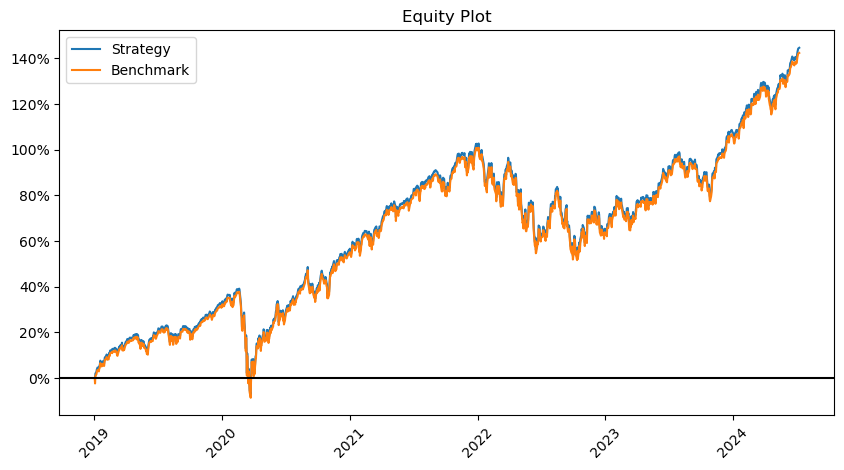

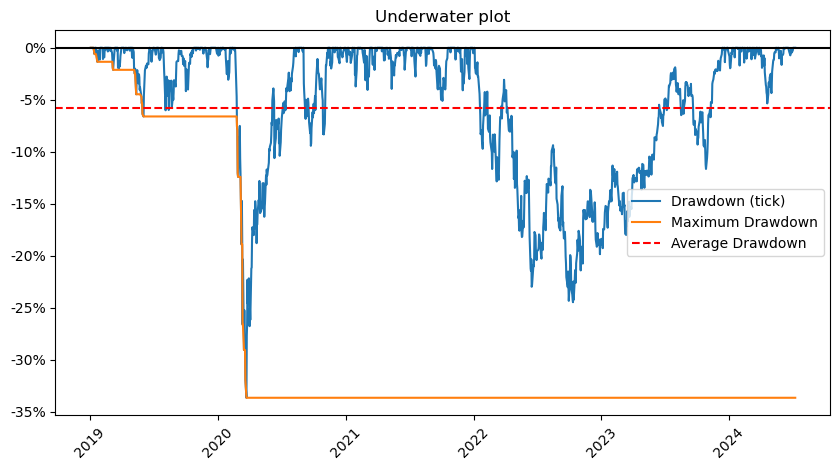

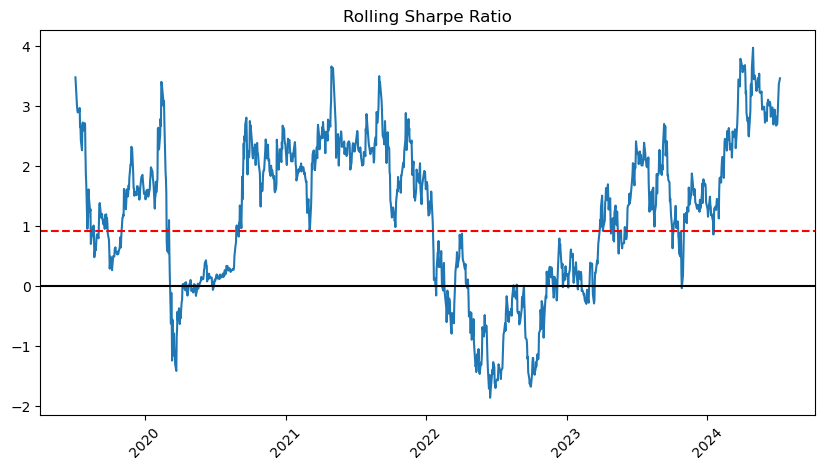

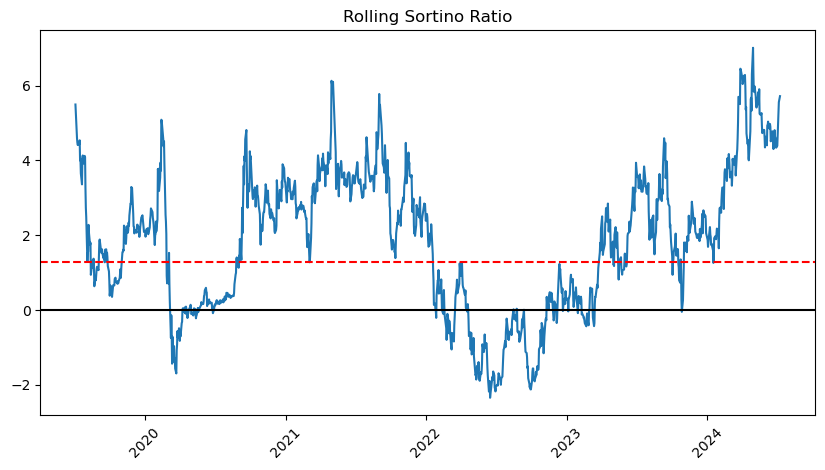

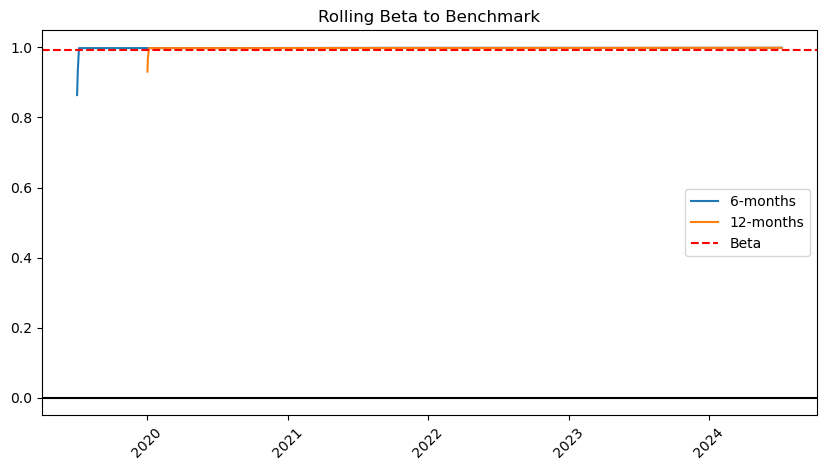

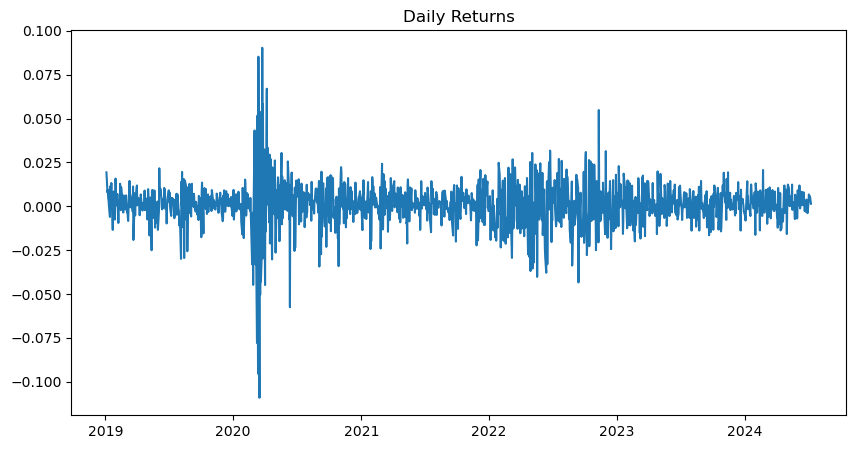

In [3]:
results = live_backtester.process_results(benchmark=BENCHMARK)
live_backtester.show_report()

In [4]:
returns = results['returns']
benchmark = results['bm_returns']

def greeks(returns, benchmark, periods=252.0):
    """Calculates alpha and beta of the portfolio"""

    # find covariance
    matrix = np.cov(returns.fillna(0), benchmark.fillna(0))
    beta = matrix[0, 1] / matrix[1, 1]

    # calculates measures now
    alpha = returns.mean() - beta * benchmark.mean()
    alpha = alpha * periods

    return pd.Series(
        {
            "beta": beta,
            "alpha": alpha,
        }
    ).fillna(0)

In [5]:
returns

Date
2019-01-03 00:00:00-05:00         NaN
2019-01-04 00:00:00-05:00    0.019341
2019-01-07 00:00:00-05:00    0.007866
2019-01-08 00:00:00-05:00    0.009374
2019-01-09 00:00:00-05:00    0.004663
                               ...   
2024-07-01 00:00:00-04:00    0.002056
2024-07-02 00:00:00-04:00    0.006723
2024-07-03 00:00:00-04:00    0.004458
2024-07-05 00:00:00-04:00    0.005761
2024-07-08 00:00:00-04:00    0.001441
Length: 1386, dtype: float64

In [6]:
benchmark

Date
2019-01-03 00:00:00-05:00   -0.023863
2019-01-04 00:00:00-05:00    0.033496
2019-01-07 00:00:00-05:00    0.007885
2019-01-08 00:00:00-05:00    0.009395
2019-01-09 00:00:00-05:00    0.004673
                               ...   
2024-07-01 00:00:00-04:00    0.002058
2024-07-02 00:00:00-04:00    0.006730
2024-07-03 00:00:00-04:00    0.004463
2024-07-05 00:00:00-04:00    0.005766
2024-07-08 00:00:00-04:00    0.001154
Name: Close, Length: 1386, dtype: float64

In [7]:
results['equity']

Date
2019-01-03 00:00:00-05:00    10000.000000
2019-01-04 00:00:00-05:00    10193.408096
2019-01-07 00:00:00-05:00    10273.593154
2019-01-08 00:00:00-05:00    10369.894180
2019-01-09 00:00:00-05:00    10418.246108
                                 ...     
2024-07-01 00:00:00-04:00    24018.736343
2024-07-02 00:00:00-04:00    24180.215591
2024-07-03 00:00:00-04:00    24288.016128
2024-07-05 00:00:00-04:00    24427.935806
2024-07-08 00:00:00-04:00    24463.135268
Length: 1386, dtype: float64

In [8]:
data['SPY']['Close'].iloc[1:]

Date
2019-01-03 00:00:00-05:00    223.637146
2019-01-04 00:00:00-05:00    231.128021
2019-01-07 00:00:00-05:00    232.950409
2019-01-08 00:00:00-05:00    235.139069
2019-01-09 00:00:00-05:00    236.237976
                                ...    
2024-07-01 00:00:00-04:00    545.340027
2024-07-02 00:00:00-04:00    549.010010
2024-07-03 00:00:00-04:00    551.460022
2024-07-05 00:00:00-04:00    554.640015
2024-07-08 00:00:00-04:00    555.280029
Name: Close, Length: 1386, dtype: float64